In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import numpy as np # linear algebra
from scipy.stats import uniform
from scipy.sparse import csr_matrix

%matplotlib inline

In [2]:
# Import the data
tweet_df = pd.read_csv("clean_preprocessed.csv")
tweet_df.columns
tweet_df = tweet_df.rename(columns={'preproc_text':'clean_text'})
cleanTweet = tweet_df.copy()[["clean_text","polarity"]]

In [3]:
# Define the sentiment carrying in the text
def text_category(tweet_polarity):
    '''A function to return the sentiment carried by a tweet text'''
    if tweet_polarity>0:
        return "positive"
    elif tweet_polarity<0:
        return "negative"
    else:
        return "neutral"

In [4]:
cleanTweet["score"] = cleanTweet["polarity"].apply(text_category)
score_sent = cleanTweet["score"].value_counts()
score_sent

neutral     6932
positive    5722
negative    2428
Name: score, dtype: int64

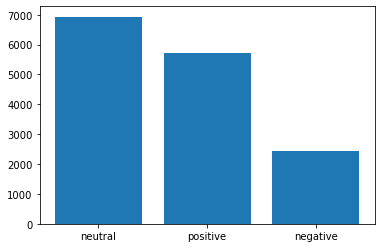

In [5]:
plt.bar(score_sent.index,score_sent.values)
plt.show()

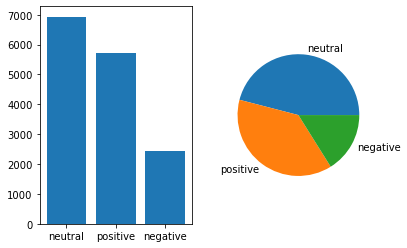

In [6]:
fig,ax = plt.subplots(1,2)
ax[0].bar(score_sent.index,score_sent.values)
ax[1].pie(score_sent,labels=['neutral','positive','negative'])
plt.show()

In [7]:
# Extract the positive and negative
cleanTweet = cleanTweet[cleanTweet["score"]!="neutral"]
cleanTweet["score"].value_counts()

positive    5722
negative    2428
Name: score, dtype: int64

In [8]:
# Re-index the frame
cleanTweet = cleanTweet.reset_index(drop=True)
cleanTweet

,clean_text,polarity,score
0,rt @northstarcharts: the -year yield is tellin...,0.160000,positive
1,rt @michaelaarouet: german y mortgage rate wen...,0.150000,positive
2,rt @biancoresearch: rates rise until something...,-0.400000,negative
3,rt @lanceroberts: buying opportunities like th...,-0.100000,negative
4,rt @macroalf: welcome to september .\n\nbond m...,0.400000,positive
...,...,...,...
8145,"rt @ferozkhaninc: in #telangana rapes, murders...",0.095455,positive
8146,"rt @ozamizcps: pssg gedson castañeros, mobile ...",0.100000,positive
8147,rt @salt_project_os: free yourself from writin...,0.400000,positive
8148,rt @pbhushan: thank you @bajpayeemanoj for thi...,0.850000,positive


In [9]:
# Create a function to encode the sentiment
def encode_sentiment(sentiment):
    '''Encode the sentiment. 1 if positive, 0 otherwise'''
    if sentiment=="positive":
        return 1
    else: return 0

In [10]:
cleanTweet['scoremap'] = cleanTweet['score'].apply(encode_sentiment)
cleanTweet['scoremap'].describe()

count    8150.000000
mean        0.702086
std         0.457370
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: scoremap, dtype: float64

In [11]:
# Create features and target variable
(X,y) = (cleanTweet['clean_text'],cleanTweet['scoremap'])

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [13]:
# Create the trigram vectorize
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit(X_train.values)

CountVectorizer(ngram_range=(3, 3))

In [14]:
trigram_vectorizer.vocabulary_

{'we must stop': 82328,
 'must stop this': 45732,
 'stop this filthy': 66948,
 'this filthy killing': 74300,
 'filthy killing in': 22708,
 'killing in ukraine': 38413,
 'systemsninja she looks': 68013,
 'she looks gorgeous': 64022,
 'rt pulte lupus': 61259,
 'pulte lupus is': 56297,
 'lupus is terrible': 41450,
 'is terrible disease': 35665,
 'terrible disease sent': 68784,
 'disease sent you': 18127,
 'sent you so': 63643,
 'you so you': 86988,
 'so you can': 65318,
 'you can get': 86542,
 'can get your': 12048,
 'get your medicine': 26153,
 'the only limit': 71828,
 'only limit to': 51521,
 'limit to your': 40300,
 'to your prosperity': 77509,
 'your prosperity is': 87389,
 'prosperity is the': 56084,
 'is the lack': 35727,
 'the lack of': 71247,
 'lack of belief': 38828,
 'of belief in': 48649,
 'belief in your': 8833,
 'in your own': 33397,
 'your own vision': 87369,
 'own vision and': 52829,
 'vision and ability': 80994,
 'and ability lineappofficial': 3095,
 'ability lineappoffic

In [15]:
df = pd.DataFrame(trigram_vectorizer.vocabulary_.items(),columns=['Vocabulary','Frequency'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87752 entries, 0 to 87751
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Vocabulary  87752 non-null  object
 1   Frequency   87752 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [16]:
df = df.sort_values(by='Frequency',ascending=False)

In [17]:
df.head(20)

,Vocabulary,Frequency
61523,𝘄𝗼𝗿𝗹𝗱 𝗵𝗮𝘀 𝗰𝗵𝗮𝗻𝗴𝗲𝗱,87751
61521,𝘄𝗵𝗶𝗰𝗵 𝘁𝗵𝗲 𝘄𝗼𝗿𝗹𝗱,87750
61519,𝘄𝗮𝘆𝘀 𝗶𝗻 𝘄𝗵𝗶𝗰𝗵,87749
61522,𝘁𝗵𝗲 𝘄𝗼𝗿𝗹𝗱 𝗵𝗮𝘀,87748
37730,𝘁𝗵𝗲 𝗠𝗼𝗻𝘁𝗵 𝗼𝗳,87747
39394,𝗿𝗲𝗮𝗱𝘆 mm_footballclub mufc,87746
37735,𝗼𝘂𝘁 𝗻𝗼𝘄 grab,87745
37732,𝗼𝗳 𝗙𝗲𝗯𝗿𝘂𝗮𝗿𝘆 𝗶𝘀,87744
37736,𝗻𝗼𝘄 grab your,87743
37734,𝗶𝘀 𝗼𝘂𝘁 𝗻𝗼𝘄,87742


In [18]:
df.tail(20)

,Vocabulary,Frequency
87511,_idontcomply_ exactly my,19
25978,_fisherofmen_ piersmorgan who,18
21743,_fels just because,17
2101,_fathima_usmaan mr bcnagesh_bjp,16
84726,_f_r_o_t_o bayaann_ follow,15
49672,_denisepaul lizzydobres sarmila_v,14
65945,_deepphilosophy deep philosophy,13
48011,_crymiariver we don,12
65413,_cingraham it always,11
21997,_cingraham confused how,10


In [19]:
X_train_trigram = trigram_vectorizer.transform(X_train.values)

Trigram Tf-Idf

In [20]:
trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_train_trigram)
X_train_trigram_tf_idf = trigram_tf_idf_transformer.transform(X_train_trigram)

SGD Classifier

In [21]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [22]:
train_and_show_scores(X_train_trigram, y_train.values, 'Trigram Counts')
train_and_show_scores(X_train_trigram_tf_idf, y_train.values, 'Trigram Tf-Idf')

Trigram Counts
Train score: 1.0 ; Validation score: 0.72

Trigram Tf-Idf
Train score: 1.0 ; Validation score: 0.72

